In [2]:
import numpy as np
import mnist
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from gaussian import gaussian
from sklearn.decomposition import PCA
import multiprocessing

In [3]:
def make_t_sne(tsne, y, title):
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout(pad=0.0)
    plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=y, cmap='Spectral')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title, fontsize=12)

In [4]:
TRAIN_SIZE = 100

In [5]:
imgs = mnist.train_images()/255.0
labels = mnist.train_labels()
data_train = imgs[0:TRAIN_SIZE, 1:, 1:]
labels_train = labels[0:TRAIN_SIZE]
subset_flattened = data_train.reshape(TRAIN_SIZE, 27*27)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


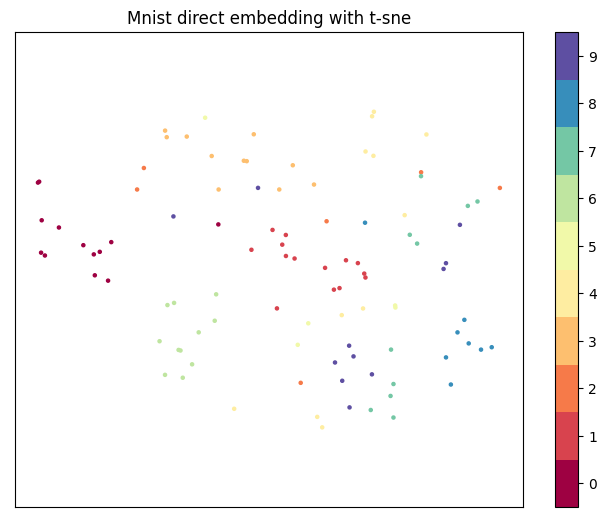

In [6]:
plt.xticks(())
plt.yticks(())
plt.tight_layout(pad=0.0)

embedding = TSNE(n_components=2, random_state=0).fit_transform(data_train.reshape(-1, 27 * 27))
#np.save('cnn1.npy', embedding)
#embedding = np.load('cnn1.npy')
make_t_sne(embedding, labels_train, "Mnist direct embedding with t-sne")

In [150]:
def calc(filters_real, filters_abs, th_i, theta):
            coefficients = np.ones((data_train.shape[0], len(filters_real))) * -1
            for image_i, image in enumerate(data_train):
                for filter_i, filter_real in enumerate(filters_real):
                    for dy in np.arange(-3, 4):
                        for dx in np.arange(-3, 4):
                            image_masked = np.roll(image,
                                                [dy, -dx] if np.isnan(theta) else [int(dy + np.rint(7 * np.sin(theta))), -int(dx + np.rint(7 * np.cos(theta)))],
                                                axis=(0, 1)) * filters_abs[filter_i]
                            image_masked /= np.sqrt(np.sum(np.square(image_masked)))
                            coefficients[image_i, filter_i] = np.max([coefficients[image_i, filter_i], np.sum(image_masked * filters_real[filter_i])])
            coefficients = np.hstack((coefficients[:, th_i[0]].max(axis=1).reshape(-1, 1), 
                                    coefficients[:, th_i[1]].max(axis=1).reshape(-1, 1),
                                    coefficients[:, th_i[2]].max(axis=1).reshape(-1, 1), 
                                    coefficients[:, th_i[3]].max(axis=1).reshape(-1, 1)))
            return coefficients

def experiment1(sig=20.):
    N = 27
    n1 = np.arange(N).reshape((-1, 1)).repeat(N, axis=1) - (N - 1) / 2
    n2 = n1.T
    n = np.array([n1, n2])
    sigma = sig
    dr = 2.
    dtheta = 0.250655662336131

    filters_real = []
    filters_abs = []
    theta_indices = [[0], [0], [0], [0]]

    frequency_domain = gaussian(n, np.array([0., 0.]), sigma, True)
    filter_real = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(frequency_domain))).real
    filters_real.append(filter_real)
    filters_abs.append(filter_real)

    for theta in np.arange(0., np.pi, dtheta):
        for r in np.arange(dr, dr * 4. + dr, dr):
            filter = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(gaussian(n, r * np.array([np.cos(theta), np.sin(theta)]), sigma, True))))
            filters_real.append(filter.real / np.sqrt(np.sum(np.square(filter.real))))
            filters_abs.append(np.abs(filter))
            if theta < np.pi / 8 or theta >= 7 * np.pi / 8:
                theta_indices[0].append(len(filters_real) - 1)
            elif theta >= np.pi / 8 and theta < 3 * np.pi / 8:
                theta_indices[1].append(len(filters_real) - 1)
            elif theta >= 3 * np.pi / 8 and theta < 5 * np.pi / 8:
                theta_indices[2].append(len(filters_real) - 1)
            elif theta >= 5 * np.pi / 8 and theta < 7 * np.pi / 8:
                theta_indices[3].append(len(filters_real) - 1)

    manifold = []
    thetas = np.hstack([[np.NaN], np.arange(0, 2 * np.pi, np.pi / 3)])

    with multiprocessing.Pool(8) as p:
        manifold += p.starmap(calc, [(filters_real, filters_abs, theta_indices, t) for t in thetas])

        # cf = calc(filters_real=filters_real, filters_abs=filters_abs, th_i=theta_indices, theta=th)
        # manifold.append(cf)
        # print("manifold", theta_i, "appended")

    manifold_reshaped = np.hstack([i for i in manifold])

    return TSNE(n_components=2, random_state=0).fit_transform(manifold_reshaped)

In [332]:
np.arange(-2, 3, 2) + 7 

array([5, 7, 9])

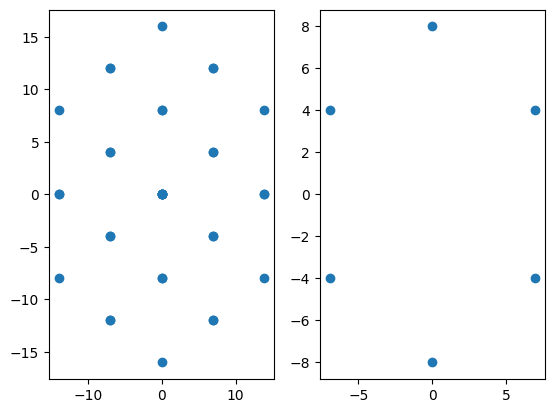

In [284]:
gg = []

visited = []
visited_2 = []


for theta in np.arange(0, 2 * np.pi, np.pi / 3):
    if ((8 * np.sin(theta), -8 * np.cos(theta)) not in visited):
        visited.append((8 * np.sin(theta), -8 * np.cos(theta)))

for tt in np.arange(0, 2 * np.pi, np.pi / 3):
    for visit in visited.copy():
        if ((visit[0] + (8 * np.sin(tt)), visit[1] + (8 * np.cos(tt))) not in visited):
            point = (visit[0] + (8 * np.sin(tt)), visit[1] - (8 * np.cos(tt)))
            visited_2.append(point)

f = set([(np.rint(i[0]), np.rint(i[1])) for i in visited_2])

for dy in np.arange(-3, 4) + point[0]:
        for dx in np.arange(-3, 4) + point[1]:
                gg.append((dy, dx))

_, ax = plt.subplots(1, 2)
x, y = zip(*visited_2)
x2, y2 = zip(*f)
x3, y3 = zip(*visited)
ax[0].scatter(x, y)
ax[1].scatter(x3, y3)


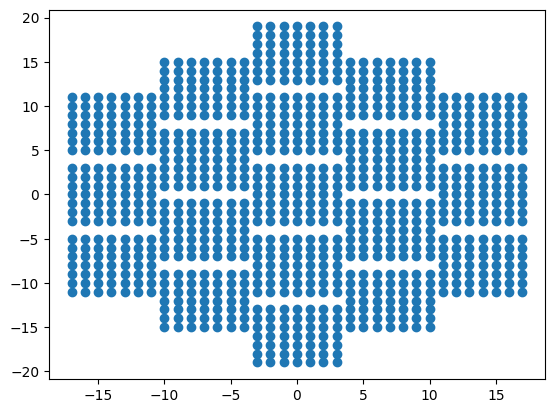

In [259]:
plt.scatter(x2, y2)

{(-14.0, 8.0), (-14.0, -8.0), (7.0, -12.0), (14.0, 8.0), (0.0, 16.0), (0.0, -16.0), (-7.0, -12.0), (-14.0, 0.0), (14.0, -0.0), (7.0, 12.0), (-7.0, 12.0), (14.0, -8.0)}


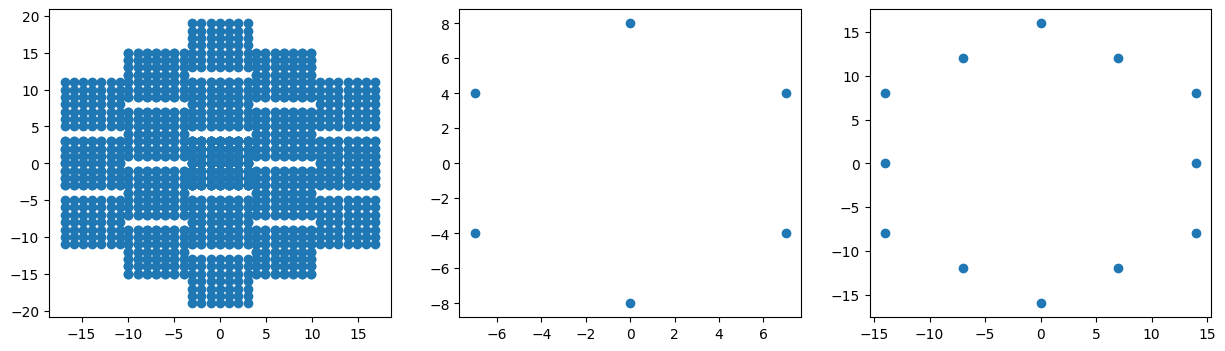

In [16]:
final = []

visited_3 = []
visited_4 = []

fin1 = {(0, 0)}

for theta in np.arange(0, 2 * np.pi, np.pi / 3):
    if ((8 * np.sin(theta), -8 * np.cos(theta)) not in visited_3):
        visited_3.append((8 * np.sin(theta), -8 * np.cos(theta)))

for tt in np.arange(0, 2 * np.pi, np.pi / 3):
    for visit in visited_3.copy():
        if ((visit[0] + (8 * np.sin(tt)), visit[1] + (8 * np.cos(tt))) not in visited_3):
            point = (visit[0] + (8 * np.sin(tt)), visit[1] - (8 * np.cos(tt)))
            visited_4.append(point)
            for dy in np.arange(-3, 4) + point[0]:
                for dx in np.arange(-3, 4) + point[1]:
                        final.append((dy, dx))

fin = set([(np.rint(i[0]), np.rint(i[1])) for i in visited_4])
fin2 = set([(np.rint(i[0]), np.rint(i[1])) for i in visited_3])
fin3 = fin - fin2 - fin1

setlist = [fin1, fin2, fin3]
arr = np.array([item for sett in setlist for item in sett])
""" print(arr)
for p in arr:
    if tuple(p) in fin3:
        for dy in np.arange(-2, 3) + p[0]:
            for dx in np.arange(-2, 3) + p[1]:
                final.append((dy, dx))
    else:
        for dy in np.arange(-2, 3) + p[0]:
            for dx in np.arange(-2, 3) + p[1]:
                final.append((dy, dx)) """

print(fin3)
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
x, y = zip(*final)
x2, y2 = zip(*fin)
x3, y3 = zip(*fin2)
x4, y4 = zip(*fin3)
ax[0].scatter(x, y)
ax[1].scatter(x3, y3)
ax[2].scatter(x4, y4)


Text(0.5, 1.0, 'Centers + roll 4')

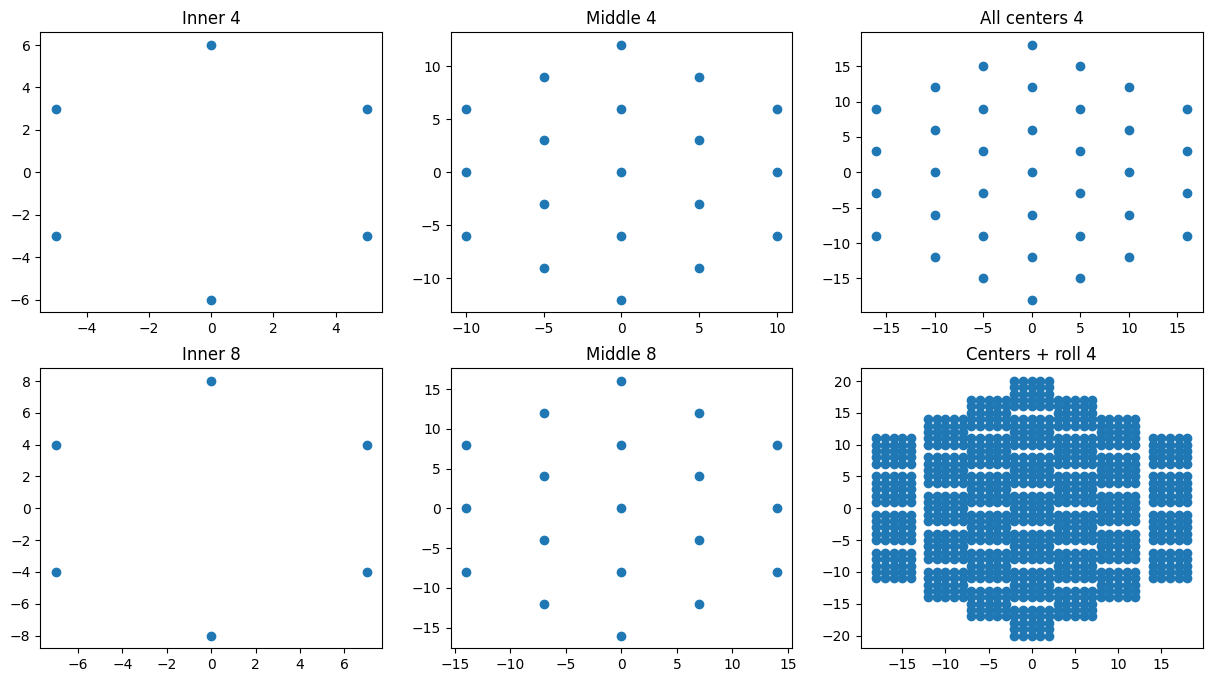

In [62]:
final = []

length = 6

v_3 = []
v_4 = []
v_5 = []
v_6 = []
v_7 = []

zero_set = {(0, 0)}

for theta in np.arange(0, 2 * np.pi, np.pi / 3):
    v_3.append((length * np.sin(theta), -length * np.cos(theta)))

for theta in np.arange(0, 2 * np.pi, np.pi / 3):
    v_4.append((8 * np.sin(theta), -8 * np.cos(theta)))

for theta_2 in np.arange(0, 2 * np.pi, np.pi / 3):
    for visit in v_3.copy():
        calc_point = (visit[0] + length * np.sin(theta_2), visit[1] + length * np.cos(theta_2))
        v_5.append(calc_point)

for tt in np.arange(0, 2 * np.pi, np.pi / 3):
    for visit in v_4.copy():
        calc_point = (visit[0] + 8 * np.sin(tt), visit[1] + 8 * np.cos(tt))
        v_6.append(calc_point)

for theta_3 in np.arange(0, 2 * np.pi, np.pi / 3):
    for visit in v_5.copy():
        calc_point = (visit[0] + length * np.sin(theta_3), visit[1] + length * np.cos(theta_3))
        v_7.append(calc_point)

fig, ax = plt.subplots(2, 3, figsize=(15, 8))

inner_4 = set([(np.rint(i[0]), np.rint(i[1])) for i in v_3])
inner_8 = set([(np.rint(i[0]), np.rint(i[1])) for i in v_4])
middle_4 = set([(np.rint(i[0]), np.rint(i[1])) for i in v_5])
middle_8 = set([(np.rint(i[0]), np.rint(i[1])) for i in v_6])
outer_4 = set([(np.rint(i[0]), np.rint(i[1])) for i in v_7])

for point in outer_4:
    for dy in np.arange(-2, 3) + point[0]:
            for dx in np.arange(-2, 3) + point[1]:
                    final.append((dy, dx))

ax[0, 0].scatter(*zip(*inner_4))
ax[0, 0].set_title("Inner 4")

ax[1, 0].scatter(*zip(*inner_8))
ax[1, 0].set_title("Inner 8")

ax[0, 1].scatter(*zip(*middle_4))
ax[0, 1].set_title("Middle 4")

ax[1, 1].scatter(*zip(*middle_8))
ax[1, 1].set_title("Middle 8")

ax[0, 2].scatter(*zip(*outer_4))
ax[0, 2].set_title("All centers 4")

ax[1, 2].scatter(*zip(*final))
ax[1, 2].set_title("Centers + roll 4")

In [326]:
setlist.index(next(s for s in setlist if (0, 0) in s))

0

49


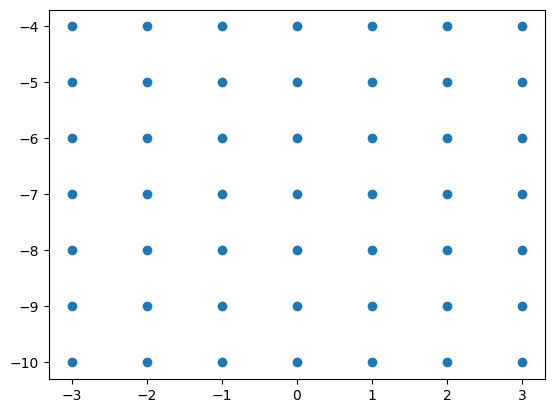

In [63]:
ll = []

for theta in np.hstack([[np.NaN], np.arange(0, 2 * np.pi, np.pi / 3)]):
    for dy in np.arange(-3, 4):
        for dx in np.arange(-3, 4):
            ll.append([dy, -dx] if np.isnan(theta) else [int(dy + np.rint(7 * np.sin(theta))), -int(dx + np.rint(7 * np.cos(theta)))])
            
print(len(ll))
x, y = zip(*ll)
plt.scatter(x, y)

In [151]:
experiment1_embedding = experiment1()
make_t_sne(experiment1_embedding, labels_train, "")

Process SpawnPoolWorker-24:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'calc' on <module '__main__' (built-in)>
Process SpawnPoolWorker-25:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.9/Frameworks/Python.frame

KeyboardInterrupt: 

In [24]:
### EMBEDDING WITH 10000 IMAGES
embedding_2 = TSNE(n_components=2, random_state=0).fit_transform(coefficients)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


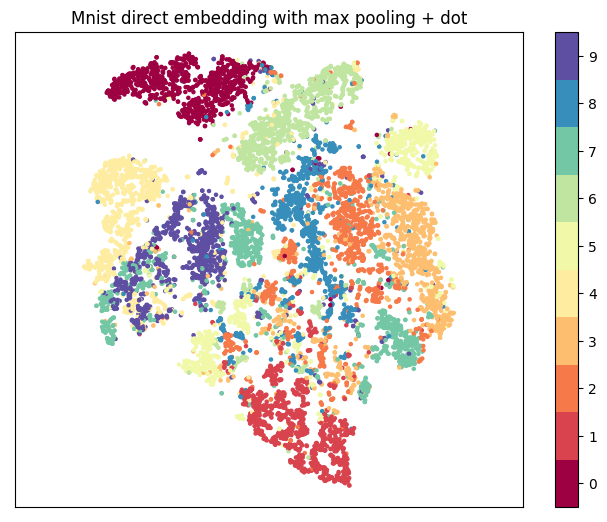

In [29]:
make_t_sne(embedding_2, labels_train, "Mnist direct embedding with max pooling + dot")

In [36]:
pca_features = PCA(n_components=2).fit_transform(coefficients)

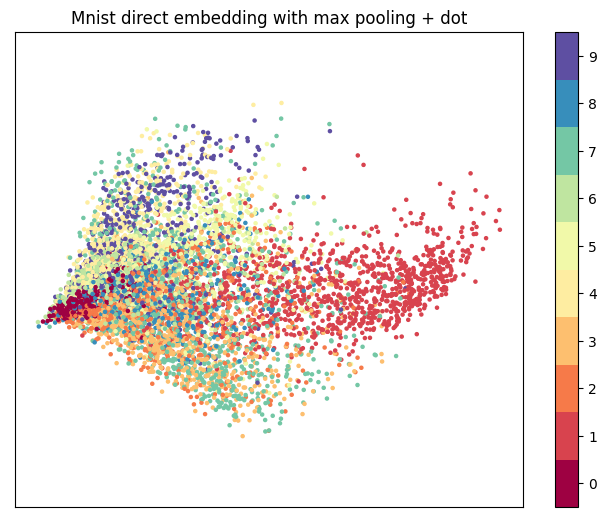

In [38]:
make_t_sne(pca_features, labels_train, "Mnist direct embedding with max pooling + dot")

In [135]:
N = 27
n1 = np.arange(N).reshape((-1, 1)).repeat(N, axis=1) - (N - 1) / 2
n2 = n1.T
n = np.array([n1, n2])
sigma_new = 10.
dr_new = 2.
dtheta = 0.250655662336131

filters_real_2 = []
filters_abs_2 = []
theta_indices_2 = [[0], [0], [0], [0]]

for theta in np.arange(0., np.pi, dtheta):
    for r in np.arange(dr_new, dr_new * 4. + dr_new, dr_new):
        filter = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(gaussian(n, r * np.array([np.cos(theta), np.sin(theta)]), sigma_new, True))))
        filters_real_2.append(filter.real / np.sqrt(np.sum(np.square(filter.real))))
        filters_abs_2.append(np.abs(filter))
        if theta < np.pi / 8 or theta >= 7 * np.pi / 8:
            theta_indices_2[0].append(len(filters_real_2) - 1)
        elif theta >= np.pi / 8 and theta < 3 * np.pi / 8:
            theta_indices_2[1].append(len(filters_real_2) - 1)
        elif theta >= 3 * np.pi / 8 and theta < 5 * np.pi / 8:
            theta_indices_2[2].append(len(filters_real_2) - 1)
        elif theta >= 5 * np.pi / 8 and theta < 7 * np.pi / 8:
            theta_indices_2[3].append(len(filters_real_2) - 1)

In [136]:
manifold_10 = []

In [137]:
for theta_i, theta in enumerate(np.hstack([[np.NaN], np.arange(0, 2 * np.pi, np.pi / 3)])):
    coefficients = np.ones((data_train.shape[0], len(filters_real_2))) * -1
    for image_i, image in enumerate(data_train):
        for filter_i, filter_real in enumerate(filters_real_2):
            for dy in np.arange(-3, 4):
                for dx in np.arange(-3, 4):
                    image_masked = np.roll(image,
                                           [dy, -dx] if np.isnan(theta) else [int(dy + np.rint(7 * np.sin(theta))), -int(dx + np.rint(7 * np.cos(theta)))],
                                           axis=(0, 1)) * filters_abs_2[filter_i]
                    image_masked /= np.sqrt(np.sum(np.square(image_masked)))
                    coefficients[image_i, filter_i] = np.max([coefficients[image_i, filter_i], np.sum(image_masked * filters_real_2[filter_i])])
                    # if np.sum(image_masked * filters_real[filter_i]) > 0.9:
                    #     print(image_i)
                    #     plt.imshow(image_masked)
                    #     plt.show()
    coefficients = np.hstack((coefficients[:, theta_indices_2[0]].max(axis=1).reshape(-1, 1), 
                              coefficients[:, theta_indices_2[1]].max(axis=1).reshape(-1, 1),
                              coefficients[:, theta_indices_2[2]].max(axis=1).reshape(-1, 1), 
                              coefficients[:, theta_indices_2[3]].max(axis=1).reshape(-1, 1)))
    manifold_10.append(coefficients)
    print("manifold", theta_i, "appended")

manifold 0 appended
manifold 1 appended
manifold 2 appended
manifold 3 appended
manifold 4 appended
manifold 5 appended
manifold 6 appended


In [138]:
manifold_10_reshaped = np.hstack([i for i in manifold_10])

In [139]:
embedding_low_10 = TSNE(n_components=2, random_state=0).fit_transform(manifold_10_reshaped)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


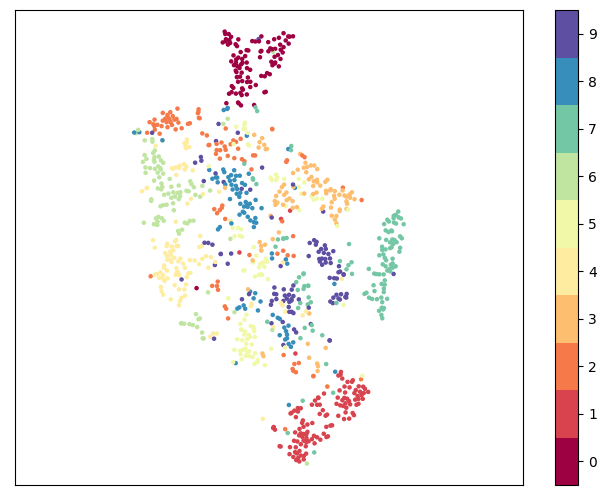

In [140]:
make_t_sne(embedding_low_10, labels_train, "")

In [108]:
test = np.hstack([i for i in manifold])
test_2 = np.hstack([j for j in manifold_10])

In [116]:
test_3 = np.concatenate((test, test_2), axis=1)

In [118]:
embedding_combined = TSNE(n_components=2, random_state=0).fit_transform(test_3)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


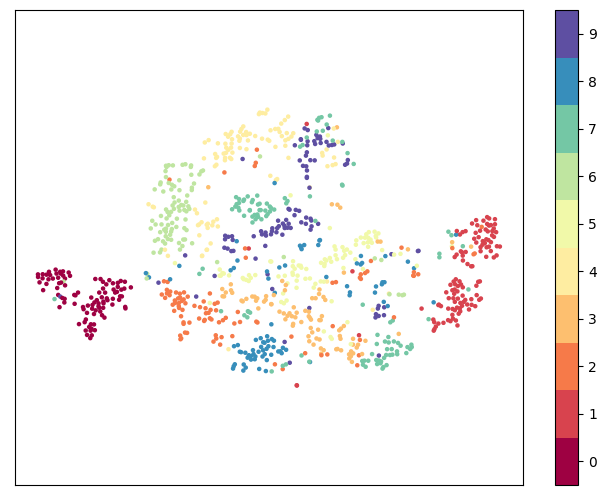

In [119]:
make_t_sne(embedding_combined, labels_train, "")

In [279]:
def calc_2(filters_real, filters_abs, th_i, point):
    coefficients = np.ones((data_train.shape[0], len(filters_real))) * -1
    for image_i, image in enumerate(data_train):
        for filter_i, _ in enumerate(filters_real):
            for dy in np.arange(-3, 4) + point[0]:
                for dx in np.arange(-3, 4) + point[1]:
                    try:
                        image_masked = np.roll(image, [dy, -dx], axis=(0, 1)) * filters_abs[filter_i]
                    except TypeError:
                        print("Error with rolling image with shape", image.shape, "and with slice", [dy, -dx])
                    image_masked *= filters_abs[filter_i]
                    image_masked /= np.sqrt(np.sum(np.square(image_masked)))
                    coefficients[image_i, filter_i] = np.max([coefficients[image_i, filter_i], np.sum(image_masked * filters_real[filter_i])])
    coefficients = np.hstack((coefficients[:, th_i[0]].max(axis=1).reshape(-1, 1),
                              coefficients[:, th_i[1]].max(axis=1).reshape(-1, 1),
                              coefficients[:, th_i[2]].max(axis=1).reshape(-1, 1),
                              coefficients[:, th_i[3]].max(axis=1).reshape(-1, 1)))
    return coefficients

In [277]:
def experiment2(sig=20.):
    N = 27
    n1 = np.arange(N).reshape((-1, 1)).repeat(N, axis=1) - (N - 1) / 2
    n2 = n1.T
    n = np.array([n1, n2])
    sigma = sig
    dr = 2.
    dtheta = 0.250655662336131

    filters_real = []
    filters_abs = []
    theta_indices = [[0], [0], [0], [0]]

    frequency_domain = gaussian(n, np.array([0., 0.]), sigma, True)
    filter_real = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(frequency_domain))).real
    filters_real.append(filter_real)
    filters_abs.append(filter_real)

    for theta in np.arange(0., np.pi, dtheta):
        for r in np.arange(dr, dr * 4. + dr, dr):
            filter = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(gaussian(n, r * np.array([np.cos(theta), np.sin(theta)]), sigma, True))))
            filters_real.append(filter.real / np.sqrt(np.sum(np.square(filter.real))))
            filters_abs.append(np.abs(filter))
            if theta < np.pi / 8 or theta >= 7 * np.pi / 8:
                theta_indices[0].append(len(filters_real) - 1)
            elif theta >= np.pi / 8 and theta < 3 * np.pi / 8:
                theta_indices[1].append(len(filters_real) - 1)
            elif theta >= 3 * np.pi / 8 and theta < 5 * np.pi / 8:
                theta_indices[2].append(len(filters_real) - 1)
            elif theta >= 5 * np.pi / 8 and theta < 7 * np.pi / 8:
                theta_indices[3].append(len(filters_real) - 1)

    manifold = []
    visited = []
    centers = []

    for theta in np.hstack([[np.NaN], np.arange(0, 2 * np.pi, np.pi / 3)]):
        if ((8 * np.sin(theta), -8 * np.cos(theta)) not in visited and not np.isnan(theta)):
            visited.append((8 * np.sin(theta), -8 * np.cos(theta)))

    for tt in np.arange(0, 2 * np.pi, np.pi / 3):
        for visit in visited.copy():
            if ((visit[0] + (8 * np.sin(tt)), visit[1] + (8 * np.cos(tt))) not in visited):
                point = (visit[0] + (8 * np.sin(tt)), visit[1] - (8 * np.cos(tt)))
                centers.append(point)

    centers = set([(np.rint(i[0]), np.rint(i[1])) for i in centers])

    for p in centers:
        manifold += calc_2(filters_real, filters_abs, theta_indices, p)

    manifold_reshaped = np.hstack([i for i in manifold])

    return TSNE(n_components=2, random_state=0).fit_transform(manifold_reshaped)

In [349]:
N = 27
n1 = np.arange(N).reshape((-1, 1)).repeat(N, axis=1) - (N - 1) / 2
n2 = n1.T
n = np.array([n1, n2])
sigma = 20.
dr = 2.
dtheta = 0.250655662336131

filters_real = []
filters_abs = []
theta_indices = [[0], [0], [0], [0]]

frequency_domain = gaussian(n, np.array([0., 0.]), sigma, True)
filter_real = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(frequency_domain))).real
filters_real.append(filter_real)
filters_abs.append(filter_real)

temp_l = [[[], [], []], [[0], [], []], [[0], [], []], [[0], [], []]]
a = 0

for t_idx, theta in enumerate(np.arange(0., np.pi, dtheta)):
    for r_idx, r in enumerate(np.arange(dr * 2 , dr * 4. + dr, dr)):
        a+=1
        if theta < np.pi / 8 or theta >= 7 * np.pi / 8:
            temp_l[0][r_idx].append(a - 1)
        elif theta >= np.pi / 8 and theta < 3 * np.pi / 8:
            temp_l[1][r_idx].append(a - 1)
        elif theta >= 3 * np.pi / 8 and theta < 5 * np.pi / 8:
            temp_l[2][r_idx].append(a - 1)
        elif theta >= 5 * np.pi / 8 and theta < 7 * np.pi / 8:
            temp_l[3][r_idx].append(a - 1)

print(temp_l[0], len(temp_l[0]))
print(temp_l[1], len(temp_l[1]))
print(temp_l[2], len(temp_l[2]))
print(temp_l[3], len(temp_l[3]))
#print(temp_l)
ring = 0
print([i[ring] for i in temp_l])
print(np.array([item for items in temp_l[ring] for item in items]).flatten())


[[0, 3, 33, 36], [1, 4, 34, 37], [2, 5, 35, 38]] 3
[[0, 6, 9, 12], [7, 10, 13], [8, 11, 14]] 3
[[0, 15, 18, 21], [16, 19, 22], [17, 20, 23]] 3
[[0, 24, 27, 30], [25, 28, 31], [26, 29, 32]] 3
[[0, 3, 33, 36], [0, 6, 9, 12], [0, 15, 18, 21], [0, 24, 27, 30]]
[ 0  3 33 36  1  4 34 37  2  5 35 38]


In [350]:
print(labels_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [300]:
for idx, g in enumerate(np.arange(dr * 2, dr * 4. + dr, dr)):
    print(idx, g)

0 4.0
1 6.0
2 8.0
